Defaulting to user installation because normal site-packages is not writeable
  Using cached Flask-2.3.2-py3-none-any.whl (96 kB)
  Using cached Werkzeug-2.3.6-py3-none-any.whl (242 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached itsdangerous-2.1.2-py3-none-any.whl (15 kB)
  Using cached blinker-1.6.2-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defau

 * Running on http://127.0.0.1:8000
Press CTRL+C to quit
127.0.0.1 - - [14/Jul/2023 02:02:17] "GET / HTTP/1.1" 200 -


apifyToken: 
link: ['https://www.instagram.com/p/CnN8rmyPtP5/', 'https://www.instagram.com/p/CnNuuEyhirj/', 'https://www.instagram.com/p/CoYoz-hOWnC/', 'https://www.instagram.com/p/CnVstOXSy83/', 'https://www.instagram.com/p/CngI0-LP5aW/', 'https://www.instagram.com/p/CnOKSP4hAeO/', 'https://www.instagram.com/p/CnOJIlBpzLm/', 'https://www.instagram.com/p/CocOljmP5Yr/', 'https://www.instagram.com/p/Cnf78BPrlAY/', 'https://www.instagram.com/p/CnjdbCcvQAu/', 'https://www.instagram.com/p/CnWigBDLDJj/', 'https://www.instagram.com/p/CnPJnVKPA3A/', 'https://www.instagram.com/p/CnRk109JpsU/', 'https://www.instagram.com/p/CnOJcN1PryS/', 'https://www.instagram.com/p/CobTZF8v17L/', 'https://www.instagram.com/p/CnOOkZoJTUN/', 'https://www.instagram.com/p/CnPaBUuSVax/', 'https://www.instagram.com/p/CnQlUtOhXcr/', 'https://www.instagram.com/p/CnOF-wFpM6V/', 'https://www.instagram.com/p/CoKjvs5Lttk/', 'https://www.instagram.com/p/CnQ5g0npO0I/', 'https://www.instagram.com/p/Cnjg7DAB-Te/', 'https://www

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['a', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'arti', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'b', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagainamakah', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasannya', 'bahwasanya', 'baik', 'baiklah', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumla

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'Positif') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1521: UserWarning: Note that pos_label (set to 'Positif') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1521: 

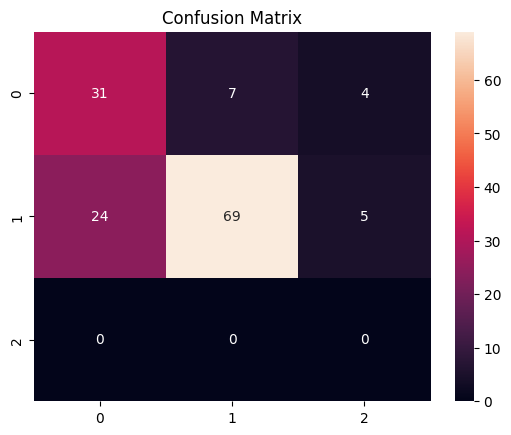

ROC	AUC	score:  0.7287
AUC for Class 0: 0.806

AUC for Class 1: 0.784

AUC for Class 2: 0.596



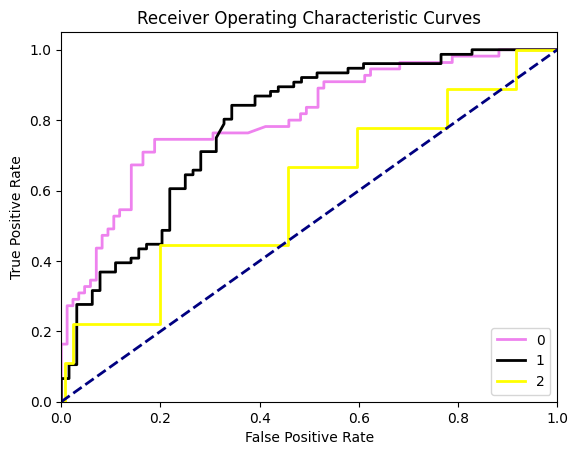

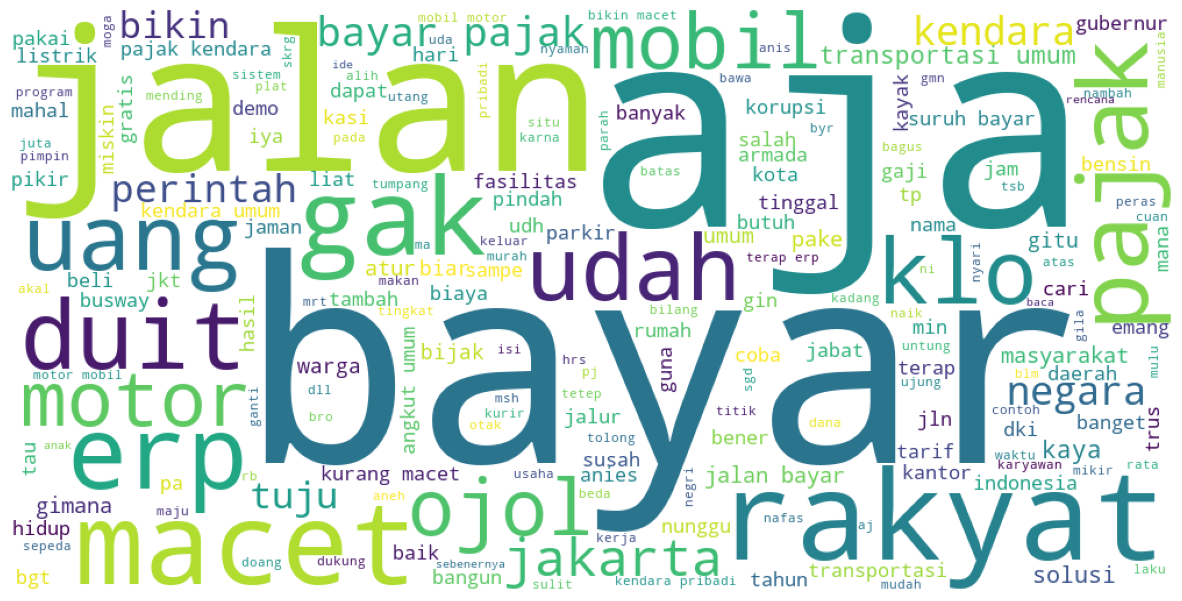

127.0.0.1 - - [14/Jul/2023 02:03:53] "POST /metodologi HTTP/1.1" 200 -


In [1]:
%pip install flask
%pip install tweet-preprocessor
%pip install textblob
%pip install sastrawi
%pip install emoji
%pip install PySastrawi
%pip install pandas
%pip install tweepy
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install wordcloud
%pip install apify-client
%pip install wordcloud

import pandas as pd
import re
import string
from textblob import TextBlob
import string
import nltk
import preprocessor as p
from preprocessor.api import clean, tokenize, parse
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import datetime
from datetime import timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import emoji
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from apify_client import ApifyClient
from flask import Flask, make_response, request
from IPython.display import display, HTML

app = Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    html_content = """
        <html>
          <body>
            <h1>Selamat Datang!</h1>
            <p>Ini adalah halaman utama website sederhana yang dibuat menggunakan Jupyter Notebook.</p>
            <form action="/metodologi" method="POST">
              <label for="apifyToken">Apify Token:</label><br>
              <input type="text" id="apifyToken" name="apifyToken"><br>
              <label for="link">Link Posting Instagram:</label><br>
              <input type="tesx" id="link" name="link"><br>
              <input type="submit">
            </form>
          </body>
        </html>
    """
    response = make_response(html_content)
    return response

@app.route('/metodologi', methods=['POST'])
def register():
    apifyToken = request.form.get('apifyToken')
    link = request.form.get('link')
    
    link = link.replace(" ","")
    link = link.split(",")
    
    print(f"apifyToken: {apifyToken}")
    print(f"link: {link}")
    
    # Initialize the ApifyClient with your API token
    client = ApifyClient("apify_api_20esNplRw082naUn9ckCu6SXMIsWcE0YCS7h")

    # Prepare the actor input
    run_input = {
      "directUrls": link,
      "resultsLimit": 1500,
    }
    
    print(run_input)
    
    # Run the actor and wait for it to finish
    run = client.actor("apify/instagram-comment-scraper").call(run_input=run_input)
    
    db_comment = pd.DataFrame(columns=["userId","createdAt","text"])
    for item in client.dataset(run["defaultDatasetId"]).iterate_items():
        value1 = item["id"]
        value2 = item["timestamp"]
        value3 = item["text"]
    
        # Create a new row with the values
        new_row = {"userId": value1, "createdAt": value2,"text": value3}
    
        # Append the new row to the DataFrame
        db_comment = pd.concat([db_comment, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    
    filename = "data-instagram.csv"
    db_comment.to_csv(filename, index=False)
    
    # ######################################################################################
    # ################################ PREPROCESSING DATA ##################################
    # ######################################################################################
    
    #Read Data
    def load_data():
      data = pd.read_csv('data-instagram.csv')
      return data
    
    comment_df = load_data()
    comment_df = pd.DataFrame(comment_df[['userId', 'createdAt', 'text']])
    print(comment_df.head(1500))

    #cleaning
    def remove_pattern(text, pattern_regex):
      r = re.findall(pattern_regex, text)
      for i in r:
        text = re.sub(i, '', text)
        return text
      
    # remove tagging
    comment_df = comment_df[comment_df['text'].notnull()]
    comment_df['clean_tagging'] = np.vectorize(remove_pattern)(comment_df['text'], " *RT* | *@[\w]*")
    print(comment_df.head(10))
    
    #remove emoji & character
    def remove(text):
      text =' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", text).split())
      return text
    comment_df['remove_character'] = comment_df['text'].apply(lambda x: remove(x))
    print(comment_df.head(9))
    
    #remove hastag
    def remov(text):
      text = re.sub(r'r\$\w*', '', text)
      text = re.sub(r'^RT[\s]+', '', text)
      text = re.sub(r'#', '', text)
      text = re.sub(r'[0-9]+', '',text)

      return text

    comment_df['remove_hastag'] = comment_df['remove_character'].apply(lambda x: remov(x))
    print(comment_df.head(10))
    
    #remove duplikat
    comment_df.drop_duplicates(subset = "remove_hastag", keep = 'first', inplace = True)
    print(comment_df.head(10))
    
    #import stopword
    nltk.download('stopwords')
    stopwords_indonesia = stopwords.words('indonesian')
    stopwords_indonesia

    stop_factory = StopWordRemoverFactory().get_stop_words()
    more_stopwords = [
        'yg', 'utk', 'cuman', 'deh', 'Btw', 'tapi', 'gua', 'gue', 'lo', 'lu',
        'kalo', 'trs', 'jd', 'nih', 'ntr', 'nya', 'lg', 'gk', 'ecusli', 'dpt',
        'dr', 'kpn', 'kok', 'kyk', 'donk', 'yah', 'u', 'ya', 'ga', 'km', 'eh',
        'sih', 'eh', 'bang', 'br', 'kyk', 'rp', 'jt', 'kan', 'gpp', 'sm', 'usah'
        'mas', 'sob', 'thx', 'ato', 'jg', 'gw', 'wkwkwk', 'mak', 'haha', 'iy', 'k'
        'tp','haha', 'dg', 'dri', 'duh', 'ye', 'wkwk', 'syg', 'btw',
        'nerjemahin', 'gaes', 'guys', 'moga', 'kmrn', 'nemu', 'yukk',
        'wkwkw', 'klas', 'iw', 'ew', 'lho', 'sbnry', 'org', 'gtu', 'bwt',
        'krlga', 'clau', 'lbh', 'cpet', 'ku', 'wke', 'mba', 'mas', 'sdh', 'kmrn',
        'oi', 'spt', 'dlm', 'bs', 'krn', 'jgn', 'sapa', 'spt', 'sh', 'wakakaka',
        'sihhh', 'hehe', 'ih', 'dgn', 'la', 'kl', 'ttg', 'mana', 'kmna', 'kmn',
        'tdk', 'tuh', 'dah', 'kek', 'ko', 'pls', 'bbrp', 'pd', 'mah', 'dhhh',
        'kpd', 'tuh', 'kzl', 'byar', 'si', 'sii', 'cm', 'sy', 'hahahaha', 'weh',
        'dlu', 'tuhh'
    ]
    data = stop_factory + more_stopwords

    dictionary = ArrayDictionary(data)
    stopWord = StopWordRemover(dictionary)

    print(data)

    #import Sastrawi
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    #tokenize
    from nltk.tokenize import TweetTokenizer

    #Happy Emoticon
    emoticons_happy = set([
        ':-)', ':)', ';)', ':o', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
        ':^)', ':-D', ':D', '8-D', '8D', ',x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
        '=-3', '=3', ':-))', ":'-)", ":')", ':*)', ':^*', '>:P', ':-P', ':P', 'X-P',
        'x-P', 'xp', ' XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
        '<3' 
    ])

    #Sad emoticon
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
      ':c', ':{', '>:\\', ';('
    ])

    #all emtoicons (happy + sad)
    emoticons = emoticons_happy.union(emoticons_sad)

    def clean_comment(comment):
      #tokenize
      tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
      comment_tokens = tokenizer.tokenize(comment)

      comments_clean = []
      for word in comment_tokens:
        if (
            word not in data and
            word not in emoticons and
            word not in string.punctuation):
            stem_word = stemmer.stem(word)
            comments_clean.append(stem_word)

      return comments_clean
    comment_df['clean_comment'] = comment_df ['remove_hastag'].apply(lambda x:clean_comment(x))
    #tokenization
    print(comment_df.head(10))
    
    #remove punct
    def remove_punct(text):
      text = " ".join([char for char in text if char not in string.punctuation])
      return text
    comment_df['clean_comment'] = comment_df ['clean_comment'].apply(lambda x:remove_punct(x))
    print(comment_df.head(10))
    
    #reset index
    comment_df = comment_df.reset_index(drop=True)
    print(comment_df.head(10))
    
    comment_df.drop_duplicates(subset ="remove_hastag", keep = 'first', inplace = True)
    print(comment_df.head(10))
    
    #remove kolom
    comment_df.drop(comment_df.columns[[0,1,2,3,4,5]], axis = 1, inplace = True)
    print(comment_df.head(1500))
    
    #simpan data bersih
    comment_df.to_csv('komentar_bersih_instagram.csv', encoding ='utf8', index = False)
    
    
    
    print("######################################################################################")
    print("################################## WEIGHT SENTIMENT ##################################")
    print("######################################################################################")
    
    df = pd.read_csv('komentar_bersih_instagram.csv', usecols=['clean_comment']).astype('str')
    print(df.head(10))
    
    # LEXICON
    lexicon = pd.read_csv('lexicon.csv')
    lexicon['weight'] = lexicon['sentiment'].map({'positive':1, 'negative':-1}) 
    lexicon = dict(zip(lexicon['word'], lexicon['weight']))
    print(lexicon)
    
    # NEGATIVE WORDS
    negative_words = list(open("negative.txt"))
    negative_words = list([word.rstrip() for word in negative_words])
    print(negative_words)
    
    comment_polarity = [] 
    comment_weight = []
    negasi = False

    for sentence in df['clean_comment']: 
      sentence_score = 0 
      sentence_weight = "" 
      sentiment_count = 0 
      sentence = sentence.split()
      for word in sentence:
        try:
          score = lexicon[word]
          sentiment_count = sentiment_count + 1
        except:
          score = 99
    
        if(score == 99):
          if (word in negative_words): 
            negasi = True
            sentence_score = sentence_score - 1
            sentence_weight = sentence_weight + " - 1"
          else:
            sentence_score = sentence_score + 0 
            sentence_weight = sentence_weight + " + 0"
        else:
          if(negasi == True):
            sentence_score = sentence_score + (score * -1.0)
            sentence_weight = sentence_weight + " + ("+ str(score) + " * -1 "+") " 
            negasi = False
          else:
            sentence_score = sentence_score + score 
            sentence_weight = sentence_weight + " + "+ str(score)
        
      comment_weight.append(sentence_weight[1:] +" = " + str(sentence_score)) 
      if sentence_score > 0:
        comment_polarity.append('positive') 
      elif sentence_score < 0:
        comment_polarity.append('negative') 
      else:
        comment_polarity.append('neutral') 

    results = pd.DataFrame({
        "comment" : df['clean_comment'], 
        "label" : comment_polarity, 
        "weight" : comment_weight
        })
    results['label'].value_counts()
    results[['comment', 'label']].to_csv('labeling-data-instagram.csv', encoding ='utf8', index = False)
    print(results.head(20))
    
    
    print("######################################################################################")
    print("#################################### DATA MINING #####################################")
    print("######################################################################################")

    df = pd.read_csv('labeling-data-instagram.csv', usecols=['comment', 'label']).dropna() 

    tf = TfidfVectorizer()
    text_tf = tf.fit_transform(df['comment'])

    temporary_df = pd.DataFrame(text_tf.todense(), columns=tf.get_feature_names_out())
    temporary_df

    from sklearn.model_selection import train_test_split
    X_train,	X_test,	y_train,	y_test	=	train_test_split(text_tf,	df['label'],	test_size=0.1, random_state=42)
    
    from sklearn.naive_bayes import MultinomialNB
    from	sklearn.metrics	import	accuracy_score,	precision_score, recall_score, f1_score
    from	sklearn.metrics	import classification_report 
    from	sklearn.metrics	import confusion_matrix

    clf = MultinomialNB().fit(X_train, y_train)
    predicted = clf.predict(X_test)
    print("Multinomial NB Accuracy  : ", accuracy_score(y_test,predicted))
    print("Multinomial NB Precision : ", precision_score(y_test,predicted, average = 'macro', pos_label="Positif"))
    print("Multinomial NB Recall    : ", recall_score(y_test,predicted, average = 'macro', pos_label="Positif"))
    print("Multinomial NB F-Measure : ", f1_score(y_test,predicted, average = 'macro', pos_label="Positif"))

    print(classification_report(y_test, predicted, zero_division=0))    
    
    import seaborn as sns 
    import matplotlib.pyplot as plt 
    cm = confusion_matrix(predicted, y_test) 
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('Confusion Matrix') 
    plt.show()
    
    predicted_proba = clf.predict_proba(X_test)
    predicted_proba
    
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score, roc_curve, auc
    print(
        f'ROC	AUC	score:  {roc_auc_score(y_test, predicted_proba[:,	:], multi_class="ovr").round(4)}')
    
    y_test_bin = label_binarize(y_test, classes=['negative', 'neutral', 'positive']) 
    n_classes = y_test_bin.shape[1]
    fpr = dict() 
    tpr = dict()
    roc_auc = dict()
    roc_auc
    colors = ['violet', 'black', 'yellow'] 
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], predicted_proba[:, i]) 
      plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label= str(i)) 
      print('AUC for Class {}: {}'.format(i, auc(fpr[i], tpr[i]).round(3)))
      print()
    # plt.figure(figsize=(12, 8))
    plt.plot([0, 1], [0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves') 
    plt.legend(loc='lower right')
    plt.show()


    isi_text = df['comment']
    isi_text
    
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    #convert list to string and generate
    unique_string=(" ").join(df['comment'])
    wordcloud = WordCloud(width = 1000, height = 500,background_color ='white').generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("wrcld"+".png", bbox_inches='tight')
    plt.show()
    plt.close()  
    
    return "Terima kasih! Data Anda telah disimpan."

if __name__ == '__main__':
    app.run(port=8000)
